#### Canny edge detection functions (previous lab work)

In [154]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [155]:
#Convolution function
def convolve2d(image, kernel, stride):
  #flip the kernel horizontally and vertically
  kernel = np.flipud(np.fliplr(kernel))

  k_sizeX, k_sizeY = kernel.shape

  im_sizeX, im_sizeY = image.shape

  #Adding padding to the image
  padding = (k_sizeX-1)/2
  image = cv2.copyMakeBorder(image,int(padding),int(padding),int(padding),int(padding),
                             cv2.BORDER_CONSTANT, value = 0)

  #output image (convolved with image)
  output_height = int((im_sizeX-k_sizeX+2*padding)/stride)+1
  output_width = int((im_sizeY-k_sizeY+2*padding)/stride)+1
  output = np.zeros((output_height,output_width))
  
  for y in range(int(padding), im_sizeY+int(padding)-k_sizeY+1,stride):
    if y > im_sizeY-k_sizeY:
      break

    for x in range(int(padding), im_sizeX+int(padding)-k_sizeX+1,stride):
      if x > im_sizeX-k_sizeX:
        break

      output[int(x/stride),int(y/stride)] = (kernel * image[x:x+k_sizeX, y:y+k_sizeY]).sum()
      
  return output

In [156]:
#Blurring function
def Blurring(image):
  GaussianKernel = np.array([[1, 4, 7, 4, 1],
                            [4, 16, 26, 16, 4],
                            [7, 26, 41, 26, 7],
                            [4, 16, 26, 16, 4],
                            [1, 4, 7, 4, 1]])
  GaussianKernel = GaussianKernel * (1/273)
  #convolving the image with the gaussian kernel
  Blurred_image = convolve2d(image, GaussianKernel, 2)
  Blurred_image = NormalizingBack(Blurred_image)
  return Blurred_image

#Normalizing function to bring back the image into range 0 to 255
def NormalizingBack(image):
  MaximumPixel = np.max(image)
  Normalized_image = (image/MaximumPixel)*255
  return Normalized_image

In [157]:
#Applying Sobel
def ApplySobel(image):
  Sx = np.array([[-1, 0, 1],
                 [ -2, 0, 2],
                 [-1, 0, 1]])
  Gx = convolve2d(image,Sx,1)
  Gx = NormalizingBack(Gx)
  Sy = np.array([[-1, -2, -1],
                 [0, 0, 0],
                 [1, 2, 1]])
  Gy = convolve2d(image,Sy,1)
  Gy = NormalizingBack(Gy)
  return Gx,Gy

In [158]:
#Function to find the gradient magnitude and direction at each pixel
def GradientOperations(Gx,Gy):
  magnitude = np.sqrt(Gx**2+Gy**2)
  magnitude = NormalizingBack(magnitude)
  direction = np.arctan2(Gy,Gx)
  return magnitude, direction

In [159]:
#Function to suppress the pixels that are not the local maximum to 0
#and to make the local maxima 255
def NonMaxSuppression(magnitude,direction):
  rows,columns = magnitude.shape
  output = np.zeros((rows,columns))

  for i in range(1,rows-1):
    for j in range(1,columns-1):
      angle = direction[i,j]

      #Dividing the unit circle into 22.5 degrees angles to make sure to get all directions
      if(15*np.pi/8 <= angle < np.pi/8) or (7*np.pi/8 <= angle < 9*np.pi/8):
        if (magnitude[i,j] > magnitude[i,j+1]) and (magnitude[i,j] > magnitude[i,j-1]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0
      elif(np.pi/8 <= angle < 3*np.pi/8) or (9*np.pi/8 <= angle < 11*np.pi/8):
        if (magnitude[i,j] > magnitude[i-1,j+1]) and (magnitude[i,j] > magnitude[i+1,j-1]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0
      elif(3*np.pi/8 <= angle < 5*np.pi/8) or (11*np.pi/8 <= angle < 13*np.pi/8):
        if (magnitude[i,j] > magnitude[i-1,j]) and (magnitude[i,j] > magnitude[i+1,j]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0
      elif(5*np.pi/8 <= angle < 7*np.pi/8) or (13*np.pi/8 <= angle < 15*np.pi/8):
        if (magnitude[i,j] > magnitude[i-1,j-1]) and (magnitude[i,j] > magnitude[i+1,j+1]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0

  output = NormalizingBack(output)
  return output

In [160]:
#Ptile thresholding function to keep the edges above a threshold T
def PTileThresholding(image, P):
  rows,columns = image.shape
  output = np.zeros((rows,columns))
  #Mapping p to the desired threshold in the image
  T = int((100-P)*(np.max(image)-np.min(image))/100)
  output[image<T] = 0
  output[image >= T] = 255
  return output

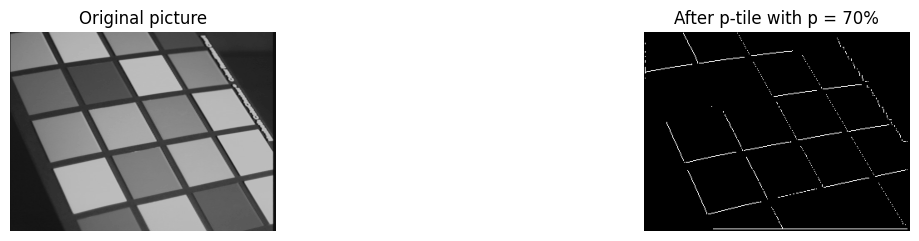

In [161]:
#Read test image and display it
input_image = cv2.imread('images/img01.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2GRAY)
plt.subplot(5,2,1)
plt.imshow(input_image, cmap='gray',vmin=0,vmax=255)
plt.title("Original picture")
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(15, 15)

#Pipeline of executing CED step-by-step
Blurred_image = Blurring(input_image)
Gx,Gy = ApplySobel(Blurred_image)
GradientMagnitude , GradientDirection = GradientOperations(Gx,Gy)
Suppressed_image = NonMaxSuppression(GradientMagnitude, GradientDirection)
ThresholdedImage = PTileThresholding(Suppressed_image,70)

#Displaying the edge detected image
plt.subplot(5,2,2)
plt.imshow(ThresholdedImage, cmap='gray',vmin=0,vmax=255)
plt.title("After p-tile with p = 70%")
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(15, 15)


#### Hough Transform functions

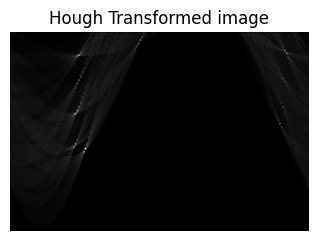

In [162]:
#HoughTrasform function
def HoughTransform(Im, rhoRes, thetaRes):
  height,width = Im.shape
  thetamin = 0
  thetamax = 2 * np.pi
  rhomin = 0
  rhomax = np.sqrt(height**2 + width**2)
  #Initializing H
  H = np.zeros((int(rhoRes),int(thetaRes)))
  #Defining rhoScale and thetaScale
  rhoScale = np.linspace(rhomin,rhomax,rhoRes)
  thetaScale = np.linspace(thetamin,thetamax,thetaRes)
  for y in range(height):
    for x in range(width):
      if Im[y,x] != 0:
        for thetaIndex, theta in enumerate(thetaScale):
          rho = x * np.cos(theta) + y * np.sin(theta)
          if rho >= rhomin and rho <= rhomax:
            rhoIndex = np.argmin(np.abs(rhoScale-rho))
            H[rhoIndex, thetaIndex] += 1
  return H, rhoScale, thetaScale

H,rhoScale,thetaScale = HoughTransform(ThresholdedImage,120,180)

plt.subplot(5,2,3)
plt.imshow(H, cmap='gray',vmin=0,vmax=255)
plt.title("Hough Transformed image")
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(15, 15)

In [163]:
def HoughNonMaxSuppression(H, neighborhood_size=5, relative_threshold=0.5):
    # Calculate the threshold based on the maximum value in H and a relative factor
    max_value = H.max()
    threshold = relative_threshold * max_value

    # Create a mask of the same size as H, initialized to False
    mask = np.zeros_like(H, dtype=bool)
    # Iterate over the Hough accumulator array
    for rho in range(0, H.shape[0]):
        for theta in range(0, H.shape[1]):
            # Get the current value
            value = H[rho, theta]
            # Define the neighborhood range
            rho_start = max(0, rho - neighborhood_size // 2)
            rho_end = min(H.shape[0], rho + neighborhood_size // 2 + 1)
            theta_start = max(0, theta - neighborhood_size // 2)
            theta_end = min(H.shape[1], theta + neighborhood_size // 2 + 1)
            # Check if the current value is greater than the threshold and all values in its neighborhood
            if value > threshold and value == np.max(H[rho_start:rho_end, theta_start:theta_end]):
                mask[rho, theta] = True
    # Get the indices of the local maxima
    peaks = np.argwhere(mask)
    return peaks

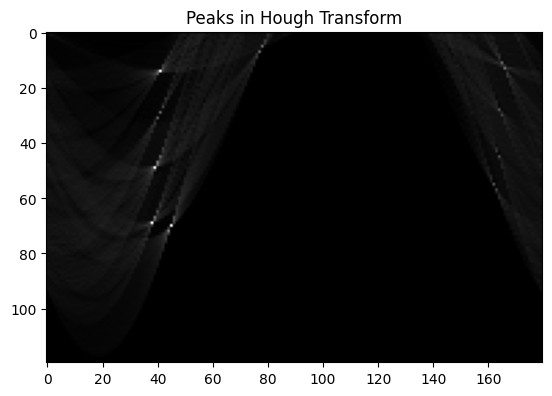

In [165]:
def visualize_peaks(H, peaks):
    H_peaks = H.copy()
    for rho_index, theta_index in peaks:
        H_peaks[rho_index, theta_index] = 255  # Mark the peak
    plt.imshow(H_peaks, cmap='gray')
    plt.title("Peaks in Hough Transform")
    plt.show()

#Finding lines function
def HoughLines(H,nLines):
  #Finding the peaks
  peaks = HoughNonMaxSuppression(H)
  # print(peaks)
  visualize_peaks(H, peaks)
  #Sorting the peaks in descending order
  sorted_peaks = sorted(peaks,key=lambda x: H[x[0],x[1]], reverse = True)
  # print(sorted_peaks[:10])
  rhos = []
  thetas = []
  for i in range(min(nLines,len(sorted_peaks))):
    peak = sorted_peaks[i]
    rho, theta = peak
    rhos.append(rho)
    thetas.append(theta)
  return rhos, thetas

rhos, thetas = HoughLines(H,20)

In [168]:
def HoughLineSegments(lineRho, lineTheta, Im):
    lines = []
    height, width = Im.shape[:2]
    for rho, theta in zip(lineRho, lineTheta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + width * (-b))
        y1 = int(y0 + width * (a))
        x2 = int(x0 - width * (-b))
        y2 = int(y0 - width * (a))
        # Clipping the line to the image boundaries
        x1, y1 = clip_line_to_image(x1, y1, width, height)
        x2, y2 = clip_line_to_image(x2, y2, width, height)
        
        lines.append({'start': [x1, y1], 'stop': [x2, y2]})
    return lines

def clip_line_to_image(x, y, width, height):
    # Clip the line coordinates to be within the image boundaries
    x = max(0, min(x, width - 1))
    y = max(0, min(y, height - 1))
    return x, y

# lines = HoughLineSegments(rhos,thetas,input_image)
lines = HoughLineSegments(rhos,thetas,ThresholdedImage)
print("Lines are: ", lines)

Lines are:  [{'start': [0, 227], 'stop': [309, 0]}, {'start': [0, 132], 'stop': [319, 0]}, {'start': [36, 0], 'stop': [0, 239]}, {'start': [0, 239], 'stop': [160, 0]}]


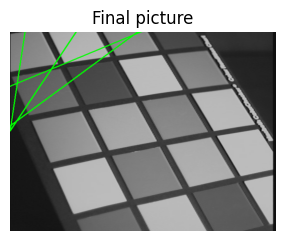

In [169]:
def drawLines(lines, Im):
    output = cv2.cvtColor(Im, cv2.COLOR_GRAY2BGR)  # Convert to BGR to draw colored lines
    for line in lines:
        x1, y1 = line['start']
        x2, y2 = line['stop']
        cv2.line(output, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green lines with thickness 2
    return output

FinalImage = drawLines(lines,input_image)

plt.subplot(5,2,4)
# plt.imshow(FinalImage, cmap='gray',vmin=0,vmax=255)
plt.imshow(FinalImage, vmin=0, vmax=255)
plt.title("Final picture")
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(15, 15)